In [1]:
import pandas as pd
import plotly.express as px
import gensim
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import hanzidentifier
import seaborn as sns

# User Level Analysis
The goal of this notebook is to analyze data on a user level.

In [2]:
users1 = pd.read_csv("../data/users1.csv")
users2 = pd.read_csv("../data/users2.csv")
users3 = pd.read_csv("../data/users3.csv")

In [3]:
users = pd.concat([users1, users2, users3])

In [4]:
tweets1 = pd.read_csv("../data/tweets1.csv")
tweets2 = pd.read_csv("../data/tweets2.csv")
tweets3 = pd.read_csv("../data/tweets3_1.csv")
tweets4 = pd.read_csv("../data/tweets3_2.csv")
tweets5 = pd.read_csv("../data/tweets3_3.csv")

//anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning:

Columns (6,15,19,30) have mixed types. Specify dtype option on import or set low_memory=False.

//anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning:

Columns (15,19,30) have mixed types. Specify dtype option on import or set low_memory=False.

//anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning:

Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.

//anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning:

Columns (1,15,30) have mixed types. Specify dtype option on import or set low_memory=False.



In [5]:
tweets = pd.concat([tweets1, tweets2, tweets3, tweets4, tweets5])

First, we write function to randomly pick a user from our dataset. Since there are a users in our dataset with no recorded tweets, we will continue to choose random users until we find one.

In [10]:
def find_random_user():
    df = None
    while df is None or df.shape[0] == 0 or hanzidentifier.has_chinese(df.iloc[0]["tweet_text"]) or hanzidentifier.has_chinese(df.iloc[3]["tweet_text"]):
        print("user")
        user = users.sample(1)["user_display_name"].item()
        df = tweets.loc[tweets["user_display_name"] == user]
    return df

Now, we will visualize the tweet frequency. In order to proceed with the same user in our future investigation, we rerun our find_random_user function until we see English results.

In [67]:
user = find_random_user()
#First, we want to see what time this specific user tweets everyday.
user["tweet_text"].head()

user


414187     Win an epic gaming rig from Tek Sydicate (in h...
765848     @CNETLive o wait isnt that features from Googl...
1142757           @CNETLive GREAT RECIPE APPLE but still OLD
1142815    @CNETLive Android Rules CM10 murders iOS 6 plu...
1142857    @CNETLive ya the iphone 5 is old technology an...
Name: tweet_text, dtype: object

In [68]:
user.shape[0]

331

In [69]:
#Visualize tweet times
user_copy = user.copy()
user_copy["tweet_time"] = pd.to_datetime(user_copy["tweet_time"]).apply(lambda x: int(x.hour))
tweet_times = user_copy.groupby("tweet_time")["userid"].count().to_frame().reset_index()
tweet_times.columns = ["hour", '# of tweets']
fig = px.line(tweet_times, x="hour", y="# of tweets")
fig.update_layout(
    title_text="@"+user["user_display_name"].iloc[0]+" Tweet Times", 
    font=dict(
        family="Times",
        size=18,
        color="#7f7f7f"
    ))
fig.show()

The goal of this part was to look for peaks of the day in which a user tweets. We expect a normal user to tweet uniformly between a 14-18 hour period.

Next, we will look at the content of the tweets, specifically their similarity.

In [70]:
user = user.sort_values("tweet_time")

At first glance, it seems like this user many of the users tweet in multiple languages. We will be using the gensim package, so first we will preprocess the data.

In [71]:
# first, remove stop words
stop_words = pd.read_csv("../data/stop_words.csv")["words"].tolist()
cleaned_tweets = user["tweet_text"].apply(lambda tweet: [x.lower() for x in [x.replace(",", "").replace(".", "").replace("!", "").replace("?", "").replace(" ", "").replace("*", "").replace('"', '').strip().lower() for x in tweet.split() if x not in stop_words] if x != ''])
cleaned_tweets = cleaned_tweets.tolist()

In [72]:
dictionary = gensim.corpora.Dictionary(cleaned_tweets)
corpus = [dictionary.doc2bow(text) for text in cleaned_tweets]

We've preprocessed the data, but knowing that there may be stop words we have missed, that there are tweets in other languages, and that users (particularly this user) tend to repeat words, we will transform our corpus using tf-idf.

In [73]:
# initialize tfidf
tfidf = gensim.models.TfidfModel(corpus, smartirs='ntc')
# computes tfidf
tfidf_corpus = tfidf[corpus]
# computes cosine similarity between each tweet and returns similarity matrix
index = gensim.similarities.MatrixSimilarity(tfidf_corpus, num_features=len(dictionary))
sims = index[tfidf_corpus]

We then wanted to visualize our similarity matrix.

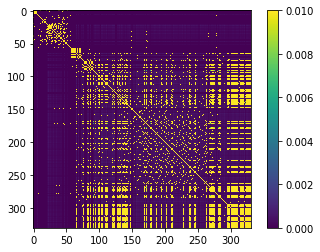

In [74]:
chart = plt.imshow(sims)
chart.set_clim(vmin=0, vmax=0.01)
plt.colorbar()
plt.show()

In [75]:
# preprocess data to fit in t-sne
# for i in range(len(sims)):
#     sims[i][i] = 0
    
# scaled
for i in range(len(sims)):
    sims[i] = sims[i]/sum(sims[i])

dis = 1.-sims

simsdf = pd.DataFrame(dis)
simsdf = simsdf.fillna(0)

In [76]:
# train model
tsne = TSNE(metric='precomputed')
Y = tsne.fit_transform(simsdf)
y = pd.DataFrame(Y)
y["year"] = pd.to_datetime(user["tweet_time"]).apply(lambda x: x.year).tolist()
simsdf["year"] = pd.to_datetime(user["tweet_time"]).apply(lambda x: x.year)

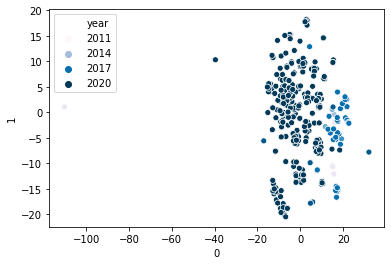

In [77]:
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
ax = sns.scatterplot(x=0, y=1, data=y, hue="year", palette="PuBu")